### In this notebook we solve 2D Elasticity with assmbled/matrix-free approaches. 

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
using NLsolve
using Random
using DataFrames
using Test

In [2]:
default(linewidth=3)
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(30 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

In [3]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square matrix by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis1D(P, Q, Qmode)
    x, _ = gausslobatto(P)
    if Qmode == "GAUSS"
        q, w = gausslegendre(Q)
    elseif Qmode == "GLL"
        q, w = gausslobatto(Q)
    else
        error("Qmode error! Choose GAUSS or GLL Quadrature points!");
    end
    V, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / V
    D = Dp / V
    x, q, w, B, D
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

function febasis2D(P, Q, num_comp, Qmode)
    # coordinate, quadrature, and basis on reference element [-1,1]
    x1_ref, q1_ref, w1_ref, B1, D1 = febasis1D(P, Q, Qmode)
    
    x, y = meshgrid(x1_ref, x1_ref)
    x2_ref = [x;y]
    qx, qy = meshgrid(q1_ref, q1_ref)
    q2_ref = [qx;qy]
    w2_ref = kron(w1_ref, w1_ref)
    
    B2 = kron(I(num_comp),kron(B1,B1))
    Dx = kron(B1, D1)
    Dy = kron(D1, B1)
    # Grad for num_comp = 1
    Dx = kron([1, 0], Dx)
    Dy = kron([0, 1], Dy)
    D2 = Dx + Dy
    D2 = kron(I(num_comp),D2)
    
    x2_ref, q2_ref, w2_ref, B2, D2
end

struct FEBasis
    P::Int
    Q::Int
    num_comp::Int
    Qmode::String
    x_ref::Vector  # nodes at 2D ref element
    q_ref::Vector  # quad pts for 2D ref element
    w_ref::Vector  # weights for 2D ref element
    B::Matrix  # Interpolation
    D::Matrix  # Derivative
    function FEBasis(P, Q, num_comp, Qmode)
        x_ref, q_ref, w_ref, B, D = febasis2D(P, Q, num_comp, Qmode)
        
        new(P, Q, num_comp, Qmode, x_ref, q_ref, w_ref, B, D)
    end
end

# Assembled approach
$$ \int_{\Omega} \nabla v \cdot \sigma = \int_{\Omega} v f, \forall v$$

In [4]:
function GetConnectivity(P, nx, ny)
    """This function returns the connectivity array

    4-------5--------6
    |       |        |
    |       |        |
    |       |        |
    1-------2--------3
    local numbering of one element is

    3-------4
    |       |
    |       |
    |       |
    1-------2


    Input:
    ------
    nx: number of element in x direction start from 1 NOT 0
    ny: number of element in y direction start from 1 NOT 0
    Output:
    ------
    idx: connectivity index of size (num_elem x P*P) based on above node numbering
    idx_bc: index for 4 faces to apply bc: [bottom, right, top, left]
    """
    n_elems = [nx, ny]
    nodes_u = zeros(Int64, 2)
    nodes_x = zeros(Int64, 2)
    for d=1:2
        nodes_u[d] = n_elems[d]*(P-1) + 1
        nodes_x[d] = n_elems[d]*(2-1) + 1
    end

    num_elem = n_elems[1] * n_elems[2]
    idx_x = zeros(Int64, 4, num_elem) # Coordinate connectivity
    idx_u = zeros(Int64, P * P, num_elem) # Solution connectivity
    for i=1:n_elems[1]
        for j=1:n_elems[2]
            ele = (j-1)*n_elems[1] + i
            for ii=1:P
                for jj=1:P
                    if (ii < 3) && (jj < 3)
                        idx_x[(ii-1) * 2 + jj, ele] = ((j-1) * (2 - 1) + ii-1) * nodes_x[1] + (i-1) * (2 - 1) + jj
                    end
                    idx_u[(ii-1) * P + jj, ele] = ((j-1) * (P - 1) + ii-1) * nodes_u[1] + (i-1) * (P - 1) + jj
                end
            end
        end
    end
    
    idx_b = Int64[] # bottom face
    idx_t = Int64[] # top face
    for i=1:n_elems[1]
        if i==1
            append!(idx_b, idx_u[1:P,i])
            append!(idx_t, idx_u[P*(P-1)+1:P*P,i + n_elems[1]*(n_elems[2] -1)])
        else
            append!(idx_b, idx_u[2:P,i])
            append!(idx_t, idx_u[P*(P-1)+2:P*P,i + n_elems[1]*(n_elems[2] -1)])
        end
    end

    idx_l = Int64[] # left face
    idx_r = Int64[] # right face
    for i=1:n_elems[1]:num_elem
        if i==1
            append!(idx_l, idx_u[1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[P:P:P*P,i+n_elems[1]-1])
        else
            append!(idx_l, idx_u[P+1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[2*P:P:P*P,i+n_elems[1]-1])
        end
    end
    
    return idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u
end


struct FEIndices
    P::Int
    nx::Int
    ny::Int
    idx_x::Matrix
    idx_u::Matrix
    idx_b::Vector
    idx_r::Vector
    idx_t::Vector
    idx_l::Vector
    nodes_u::Vector
    Er_x::Vector
    Er_u::Vector
    function FEIndices(P, num_comp, nx, ny)
        idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u = GetConnectivity(P, nx, ny)
        
        # number of nodes
        dof_u = maximum(idx_u)
        dof_x = maximum(idx_x)
        # element dof
        elem_dof_u = size(idx_u, 1)
        elem_dof_x = size(idx_x, 1)
        num_elem = size(idx_x, 2)
        # element restriction operator
        Er_x = []
        Er_u = []
        for e = 1:num_elem
            Lx = spzeros(Int64, elem_dof_x, dof_x)
            Lu = spzeros(Int64, elem_dof_u, dof_u)
            for i=1:elem_dof_u
                if i < elem_dof_x + 1
                    Lx[i, idx_x[i, e] ] = 1
                end
                Lu[i, idx_u[i, e] ] = 1
            end
            Lx = kron(I(2), Lx)
            Lu = kron(I(num_comp), Lu)
            push!(Er_x, Lx)
            push!(Er_u, Lu)
        end
        
        new(P, nx, ny, idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u, Er_x, Er_u)
    end
end

In [5]:
function GetCoordNodes(mesh, nelx, nely, aspect_ratio)
    """ This function returns the physical coordinates of the nodes.
    Input:
    ------
    nelx:   integer
            number of elements in the x direction.
    nely:   integer
            number of elements in the y direction.
    mesh: can be unifrom or nonuniform

    Output:
    -------
    x:      float (1d array)
            the coordinate of the node in the x direction
    y:      float (1d array)
            the coordinate of the node in the y direction
    The geometry we are working on is like the following.
    (for nelx = 2, nely = 2)
    6---------7----------8
    |         |   (3)    |
    |   (2)   |      ----5
    |      ---4-----/    |
    3-----/   |   (1)    |
    |         |      ----2
    |   (0)   |     /
    |     ----1----/
    0----/
    There are 4 elements (numbering in parenthesis), and 9 nodes.
    This function returns x,y as 9x2 array for the above mesh.
    """
    nodex = nelx + 1
    nodey = nely + 1
    numnodes = nodex*nodey
    # interior nodes for random mesh
    interiornodex = nelx - 1
    interiornodey = nely - 1
    interiornodes = interiornodex*interiornodey

    hx = 1/nelx
    hy = 1/(nely*aspect_ratio)
    h = minimum([hx hy])
    
    if (aspect_ratio <1)
        error!("aspect_ratio must be bigger than 1")
    end

    # Divide [0,1] by nodex (mesh in the x direction)
    x0 = LinRange(0, 1, nodex)
    if mesh == "uniform"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    elseif mesh == "random"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        Random.seed!(1234)
        randnodes_x = rand(interiornodes,1)*hx/2 .- hx/4
        randnodes_y = rand(interiornodes,1)*hy/2 .- hy/4
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes_x[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - randnodes_y[j+(i-1)*interiornodex]
            end
        end
        
    elseif mesh == "trapezoid"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                #x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - (-1)^j *(h/4)
            end
        end

    else
        error("Enter one of the mesh option: 'unifrom', 'trapezoid', 'random' ")
    end
    
    #
    return x, y

end

function plotmesh(mesh, xn, yn, idx_x)

    p = plot()
    nodes = [1 2 4 3 1]
    xx = zeros(5,1)
    yy = zeros(5,1)
    num_elem = size(idx_x, 2)
    for i = 1:num_elem
        for j =1:5
        xx[j] = xn[idx_x[nodes[j],i]] 
        yy[j] = yn[idx_x[nodes[j],i]] 
        end
        plot!(p,xx,yy,color="black",legend=false)
    end
    
    return p
end

function GetCoordElem(xn, yn, Er_x, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (8,1) array
    which is [x;y] coordinates of the 4 nodes
    """
    
    return Er_x[e]*[xn; yn]
end

GetCoordElem (generic function with 1 method)

In [6]:
function GetQdata(Coord_E, Bx::FEBasis)
    J1 = Bx.D*Coord_E
    J2 = reshape(J1, Bx.Q^2, :)
    J = zeros(Bx.Q^2, 2, 2)
    detJ = zeros(Bx.Q^2)
    dXdx_T = zeros(Bx.Q^2, 2, 2)
    for i=1:Bx.Q^2
        J[i,:,:] = reshape(J2[i,:], 2, 2)
        detJ[i] = det(J[i,:,:])
        dXdx_T[i,:,:] = I/J[i,:,:]
    end
    
    # quadrature pts in elmenet E
    q = Bx.B * Coord_E
    
    wdetJ = Bx.w_ref .* detJ;
    
    return q, wdetJ, dXdx_T
end

function GetRhsLocal(lambda, mu, wdetJ, q, f, Bu::FEBasis)
    
    W2 = diagm(wdetJ);
    if Bu.num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    xq = reshape(q, Bu.Q^2,:)
    Fe = Bu.B' * W2 * f(lambda, mu, xq[:,1], xq[:,2])  # v^T * f
    return Fe
end

function GetStressLocal(lambda, mu, wdetJ, dXdx_T, Bu::FEBasis)
    
    W2 = diagm([wdetJ; wdetJ]);
    if Bu.num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end
    # save sigma = lambda tr(e) I + 2 mu e; where e = 0.5*(grad_u + grad_u^T)
    s = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.D,2))
    for i=1:Bu.Q^2
        D1 = zeros(2, size(Bu.D,2))
        D1[1,:] = Bu.D[i,:]
        D1[2,:] = Bu.D[i + Bu.Q^2,:]
        grad_u1 = dXdx_T[i,:,:] * D1
        D2 = zeros(2, size(Bu.D,2))
        D2[1,:] = Bu.D[i + 2*Bu.Q^2,:]
        D2[2,:] = Bu.D[i + 3*Bu.Q^2,:]
        grad_u2 = dXdx_T[i,:,:] * D2
        tr_e = grad_u1[1,:] + grad_u2[2,:]
        s11 = lambda * tr_e + 2 * mu * grad_u1[1,:]
        s12 = mu * (grad_u1[2,:] + grad_u2[1,:])
        s22 = lambda * tr_e + 2 * mu * grad_u2[2,:]
        S1 = dXdx_T[i,:,:]' * vcat(s11', s12')
        S2 = dXdx_T[i,:,:]' * vcat(s12', s22')

        s[i,:] = S1[1,:]
        s[i + Bu.Q^2,:] = S1[2,:]
        s[i + 2*Bu.Q^2,:] = S2[1,:]
        s[i + 3*Bu.Q^2,:] = S2[2,:]
    end
    
    Ke = Bu.D' * W2 * s  # grad(v)^T * sigma
    
    return Ke
end

function GetDirichletBCsIndex(num_comp, Ind::FEIndices)
    num_nodes = Ind.nodes_u[1] * Ind.nodes_u[2]
    bc_idx = Int64[]
    for c=0:num_comp -1
        # bottom
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_b[i] .+ c * num_nodes)
        end
        # right
        for j=1:Ind.nodes_u[2]
            append!(bc_idx, Ind.idx_r[j] .+ c * num_nodes)
        end
        # top
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_t[i] .+ c * num_nodes)
        end
        # left
        for j=1:Ind.nodes_u[2]
            append!(bc_idx, Ind.idx_l[j] .+ c * num_nodes)
        end
    end
    
    return bc_idx
end

function GetFEElasticity(lambda, mu, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_u)
    F = spzeros(Bu.num_comp*global_dof, 1)
    K = spzeros(Bu.num_comp*global_dof,Bu.num_comp*global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        Ke = GetStressLocal(lambda, mu, wdetJ, dXdx_T, Bu)
        Fe = GetRhsLocal(lambda, mu, wdetJ, q, f, Bu);  # v^T * f

        # Assemble
        K = K + Ind.Er_u[e]' * Ke * Ind.Er_u[e]
        F = F + Ind.Er_u[e]' * Fe

    end
    # Apply Dirichlet BCs
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
    F[bc_idx].= 0
    K[bc_idx,:] .= 0.
    for i=1:length(bc_idx)
        K[bc_idx[i], bc_idx[i]] = 1.
    end
    
    u = K \ F
    
   return u 
end

function GetL2Error(xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, uh, uex)
    """This function returns L2 error 
    (sum_{e=1:num_elem} (int_e (uh - uex)^2 dx) )^0.5 
    """

    num_elem = size(Ind.idx_u,2)

    e_u = zeros(num_elem)
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ = GetQdata(Coord_E, Bx);

        if num_comp == 2
            wdetJ = [wdetJ; wdetJ]
        end
        
        # dh is the nodal value for element e
        dh = Ind.Er_u[e] * uh
        # Compute uh(x) in quadrature x=q in L2 space 
        u_num = Bu.B * dh
        
        xq = reshape(q, Q^2,:)
        u_ex = uex(xq[:,1], xq[:,2]) 

        err_u = vec((u_num - u_ex))
        # \int (u_num - u_ex)^2 dx ==> on element e
        e_u[e] = wdetJ' * (err_u .* err_u)

    end

    return sqrt(sum(e_u))
end

GetL2Error (generic function with 1 method)

In [7]:
# P is number of nodes in 1D, so P=2 means linear Q1 element
P, num_comp, Qmode = 2, 2, "GAUSS"
Q = P
Bx = FEBasis(2, Q, 2, Qmode);
Bu = FEBasis(P, Q, num_comp, Qmode);
nx, ny, mesh, aspect_ratio= 2, 2, "uniform", 1
xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, num_comp, nx, ny);
lambda, mu = 3, 1.

function uex(x, y)
    ux = @. sin(pi*x)*sin(pi*y)
    uy = @. 2*ux 
    return [ux; uy]
end

function f(lambda, mu, x, y)
    
    ux = @. sin(pi*x)*sin(pi*y)
    uy = @. 2*ux 
    
    ux_xx = @. -pi^2 * ux
    ux_yy = @. -pi^2 * ux
    uy_xx = @. 2 * ux_xx
    uy_yy = @. 2 * ux_yy
    ux_xy = @. pi * pi * cos(pi*x) * cos(pi*y)
    uy_yx = @. 2 * ux_xy
    
    fx = @. -mu * (ux_xx + ux_yy) - (mu + lambda) * (ux_xx + uy_yx)
    fy = @. -mu * (uy_xx + uy_yy) - (mu + lambda) * (ux_xy + uy_yy) 
    return [fx; fy]
end

uh2 = GetFEElasticity(lambda, mu, xn, yn, Ind, Bx, Bu, f);
L2_error = GetL2Error(xn, yn, Ind, Bx, Bu, uh2, uex)

0.2264136406109871

# <font color='red'> Matrix-Free approach


In [8]:
# This is like libCEED/Ratel Residual Qfunction
function Compute_f0(lambda, mu, Q, num_comp, wdetJ, q, uq, f)
    W2 = diagm(wdetJ);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    xq = reshape(q, Q^2,:)
    W2 * (uq - f(lambda, mu, xq[:,1], xq[:,2]))
end

function Compute_f1(lambda, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq)
    W2 = diagm([wdetJ; wdetJ]);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end
    
    # sigma = lambda tr(e) I + 2 mu e; where e = 0.5*(grad_u + grad_u^T)
    s = zeros(2 * num_comp * Q^2)
    for i=1:Q^2
        grad_u1 = dXdx_T[i,:,:] * [Duq[i], Duq[i + Q^2]]
        grad_u2 = dXdx_T[i,:,:] * [Duq[i + 2*Q^2], Duq[i + 3*Q^2]]
        tr_e = grad_u1[1] + grad_u2[2]
        s11 = lambda * tr_e + 2 * mu * grad_u1[1]
        s12 = mu * (grad_u1[2] + grad_u2[1])
        s22 = lambda * tr_e + 2 * mu * grad_u2[2]
        S1 = dXdx_T[i,:,:]' * vcat(s11', s12')
        S2 = dXdx_T[i,:,:]' * vcat(s12', s22')

        s[i] = S1[1]
        s[i + Q^2] = S1[2]
        s[i + 2*Q^2] = S2[1]
        s[i + 3*Q^2] = S2[2]
    end
    
    W2 * s

end

function Compute_df0(lambda, mu, Q, num_comp, wdetJ, q, uq, du, f)
    W2 = diagm(wdetJ);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ])
    end
    W2 * du
end

function Compute_df1(lambda, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq, Ddu)
    W2 = diagm([wdetJ; wdetJ]);
    if num_comp == 2
        W2 = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    end
    
    ds = zeros(2 * num_comp * Q^2)
    for i=1:Q^2
        grad_du1 = dXdx_T[i,:,:] * [Ddu[i], Ddu[i + Q^2]]
        grad_du2 = dXdx_T[i,:,:] * [Ddu[i + 2*Q^2], Ddu[i + 3*Q^2]]
        tr_de = grad_du1[1] + grad_du2[2]
        ds11 = lambda * tr_de + 2 * mu * grad_du1[1]
        ds12 = mu * (grad_du1[2] + grad_du2[1])
        ds22 = lambda * tr_de + 2 * mu * grad_du2[2]
        dS1 = dXdx_T[i,:,:]' * vcat(ds11', ds12')
        dS2 = dXdx_T[i,:,:]' * vcat(ds12', ds22')

        ds[i] = dS1[1]
        ds[i + Q^2] = dS1[2]
        ds[i + 2*Q^2] = dS2[1]
        ds[i + 3*Q^2] = dS2[2]
    end
    
    W2 * ds
end

Compute_df1 (generic function with 1 method)

In [9]:
function ElasticityResidual(lambda, mu, u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    u = copy(u_in); v = zero(u)
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0
    
    num_elem = size(Ind.idx_u,2)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        ue = Ind.Er_u[e] * u
        uq = 0 * Bu.B * ue
        Duq = Bu.D * ue
        
        f0 = Compute_f0(lambda, mu, Bu.Q, Bu.num_comp, wdetJ, q, uq, f)
        f1 = Compute_f1(lambda, mu, Bu.Q, Bu.num_comp, wdetJ, dXdx_T, q, Duq)
        ve = Bu.B' * f0 + Bu.D' * f1
        v += sparse(Ind.Er_u[e]') * ve
    end   
    v[bc_idx] = u_in[bc_idx] - u[bc_idx]
    v

end

function ElasticityJacobian(lambda, mu, u_in, xn, yn, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f)

    u = copy(u_in);
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind)
    u[bc_idx] .= 0
    
    num_elem = size(Ind.idx_u, 2)
    rows, cols, vals = Int[], Int[], Float64[]
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xn, yn, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        ue = Ind.Er_u[e] * u
        Duq = Bu.D * ue
        Jac = zeros(Bu.num_comp * Bu.P * Bu.P, Bu.num_comp * Bu.P * Bu.P);
        for c=0:Bu.num_comp-1
            for j=1:Bu.P * Bu.P
                Ddu = Bu.D[:,j + c*Bu.P * Bu.P]
                df1 = Compute_df1(lambda, mu, Bu.Q, Bu.num_comp, wdetJ, dXdx_T, q, Duq, Ddu)
                Jac[:,j + c*Bu.P * Bu.P] = Bu.D' * df1
            end
        end
        inds = rowvals(sparse(Ind.Er_u[e]'))
        append!(rows, kron(ones(Bu.num_comp * Bu.P * Bu.P), inds))
        append!(cols, kron(inds, ones(Bu.num_comp * Bu.P * Bu.P)))
        append!(vals, vec(Jac))
    end   
    A = sparse(rows, cols, vals)
    A[bc_idx,:] .= 0.; A[:, bc_idx] .= 0.
    for i=1:length(bc_idx)
        A[bc_idx[i], bc_idx[i]] = 1.
    end
    A

end

ElasticityJacobian (generic function with 1 method)

In [10]:
global_dof = maximum(Ind.idx_u)
u_dof = Bu.num_comp*global_dof;

u0 = zeros(u_dof);
uh = nlsolve(u -> ElasticityResidual(lambda, mu, u, xn, yn, Ind, Bx, Bu, f),
             u -> ElasticityJacobian(lambda, mu, u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton)
L2_error = GetL2Error(xn, yn, Ind, Bx, Bu, uh.zero, uex)

0.2264136406109872

# <font color='blue'> Convergence study: Assembled 

In [11]:
# P is number of nodes in 1D, so P=2 means linear Q1 element
P, num_comp, Qmode = 3, 2, "GAUSS"
Q = P
Bx = FEBasis(2, Q, 2, Qmode);
Bu = FEBasis(P, Q, num_comp, Qmode);
nx, ny, mesh, aspect_ratio= 2, 2, "uniform", 1 # aspect ratio of the element
xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, num_comp, nx, ny);
lambda, mu = 3e4, 1.;
nu = 0.5*lambda/(lambda + mu)
E = 2*mu*(1+nu)
@show nu, E

(nu, E) = (0.4999833338888704, 2.999966667777741)


(0.4999833338888704, 2.999966667777741)

In [12]:
N = 4
res = 4 .*(1:N)
eu = zeros(N)
order_u = []
append!(order_u, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, num_comp, nx, ny);
    uh = GetFEElasticity(lambda, mu, xn, yn, Ind, Bx, Bu, f);
    L2_error = GetL2Error(xn, yn, Ind, Bx, Bu, uh, uex)
    
    eu[i] = L2_error
    
    #h = Gethsz(xn, yn, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u, log10(eu[i]/eu[i-1])/logH)
    end
end

In [13]:
# P is number of nodes/elem in 1D, convergence order should be "P", It might be super-convergent
df = DataFrame("N" => res, "Elasticity Error" => eu, "Order u" => order_u)
println("***********************************************************************\n")
println("Convergence study (Assembled) for 2D Elasticity for nu:$nu , with $mesh mesh and P:$P \n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (Assembled) for 2D Elasticity for nu:0.4999833338888704 , with uniform mesh and P:3 

***********************************************************************

4×3 DataFrame
 Row │ N      Elasticity Error  Order u 
     │ Int64  Float64           Any     
─────┼──────────────────────────────────
   1 │     4       0.0103441    0
   2 │     8       0.00216306   2.25766
   3 │    12       0.000916885  2.11682
   4 │    16       0.000505601  2.06907


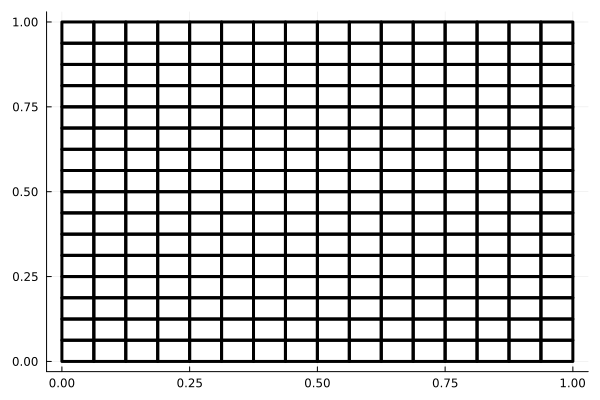

In [14]:
plotmesh(mesh, xn, yn, Ind.idx_x)

# <font color='blue'> Convergence study: Matrix-Free 

In [15]:
N = 4
res = 4 .*(1:N)
eu = zeros(N)
order_u = []
append!(order_u, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xn, yn = GetCoordNodes(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, num_comp, nx, ny);
    
    global_dof = maximum(Ind.idx_u)
    u_dof = Bu.num_comp*global_dof;
    u0 = zeros(u_dof);
    uh = nlsolve(u -> ElasticityResidual(lambda, mu, u, xn, yn, Ind, Bx, Bu, f),
                 u -> ElasticityJacobian(lambda, mu, u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton)
    L2_error = GetL2Error(xn, yn, Ind, Bx, Bu, uh.zero, uex)
    
    eu[i] = L2_error
    
    #h = Gethsz(xn, yn, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u, log10(eu[i]/eu[i-1])/logH)
    end
end

In [16]:
# P is number of nodes/elem in 1D, convergence order should be "P", It might be super-convergent
df = DataFrame("N" => res, "Elasticity Error" => eu, "Order u" => order_u)
println("***********************************************************************\n")
println("Convergence study (Matrix-Free) for 2D Elasticity for nu:$nu , with $mesh mesh and P:$P \n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (Matrix-Free) for 2D Elasticity for nu:0.4999833338888704 , with uniform mesh and P:3 

***********************************************************************

4×3 DataFrame
 Row │ N      Elasticity Error  Order u 
     │ Int64  Float64           Any     
─────┼──────────────────────────────────
   1 │     4       0.0103441    0
   2 │     8       0.00216306   2.25766
   3 │    12       0.000916885  2.11682
   4 │    16       0.000505601  2.06907


In [17]:
# check the time for the last size of refinement 16x16
@time GetFEElasticity(lambda, mu, xn, yn, Ind, Bx, Bu, f);

  7.188586 seconds (139.43 k allocations: 18.278 GiB, 14.96% gc time)


In [18]:
global_dof = maximum(Ind.idx_u)
u_dof = Bu.num_comp*global_dof;
u0 = zeros(u_dof);

In [19]:
@time nlsolve(u -> ElasticityResidual(lambda, mu, u, xn, yn, Ind, Bx, Bu, f),
              u -> ElasticityJacobian(lambda, mu, u, xn, yn, Ind, Bx, Bu, f), u0; method = :newton);

  0.297969 seconds (1.33 M allocations: 390.970 MiB, 12.58% gc time, 7.42% compilation time)


In [20]:
# Note to myself: I need to define residual and Jaocbian for assembled approach so I can use nlsolve for both method